### Set Up the Environment

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
import torch
import torch.autograd as autograd
import torch.optim as optim
from copy import deepcopy, copy
from collections import namedtuple, deque

def reset_env(env, *args, **kwargs):
    result = env.reset(*args, **kwargs)
    return result[0] if isinstance(result, tuple) else result

def step_env(env, action):
    result = env.step(action)
    if isinstance(result, tuple) and len(result) == 5:
        observation, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        observation, reward, done, info = result
    return observation, reward, done, info

def render_env(env):
    frame = env.render()
    if isinstance(frame, (list, tuple)):
        frame = frame[0]
    return frame


In [3]:
class DQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, neuronas=16):
        super(DQN, self).__init__()
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        ### Neural network construction
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, neuronas, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(neuronas, neuronas, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(neuronas, self.n_outputs, bias=True))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        
        ### Optional CUDA support
        if self.device == 'cuda':
            self.model.cuda()
            
    
    ### E-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # random action
        else:
            qvals = self.get_qvals(state)  # action derived from computing the Q-value for that action
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.model(state_t)

Define the experience replay buffer

In [4]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    ## We create a list of random indices and pack the experiences into NumPy arrays (this simplifies the later loss computation)
    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    ## Add new experiences 
    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    ## Fill the buffer with random experiences at the beginning of training
    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

The burn-in lets us fill the buffer at the start of training (when the agent has not yet begun to explore) with random experiences so it is full enough to start training with a broad variety of information. 

#### Agent definition

In [5]:
class DQNAgent:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.env = env
        self.dnnetwork = dnnetwork
        self.target_network = deepcopy(dnnetwork) # target network (copy of the main network)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # block size of the last X episodes used to compute the mean reward
        self.reward_threshold = self.env.spec.reward_threshold # average reward at which it is considered
                                                               # that the agent has learned to play
        self.initialize()
    
    
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = reset_env(self.env)
        self.training_loss = []
        self.epsilon_values = []
        
    
    ## Take a new action
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            # random action during burn-in and the exploration phase (epsilon)
            action = self.env.action_space.sample() 
        else:
            # action based on the Q-value (chooses the action with the highest Q)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Execute the action and obtain the new state and reward
        new_state, reward, done, _ = step_env(self.env, action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # store the experience in the buffer
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = reset_env(self.env)
        return done

    
        
    ## Training
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Fill the buffer with N random experiences
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = reset_env(self.env)
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # The agent takes an action
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Update the main network according to the configured frequency
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Synchronize the main and target networks according to the configured frequency
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                
                if gamedone:                   
                    episode += 1
                    self.training_rewards.append(self.total_reward) # store the obtained rewards
                    self.epsilon_values.append(self.epsilon)
                    self.training_loss.append(sum(self.update_loss))
                    self.update_loss = []
                    mean_rewards = np.mean(   # compute the mean reward over the last X episodes
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    # Check that episodes remain
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # Stop training if the mean reward has reached the threshold set for this environment  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                    
                    # Update epsilon according to the chosen decay rate
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    
                
    ## Loss calculation                   
    def calculate_loss(self, batch):
        # Separate the experience variables and convert them to tensors 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device) 
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.dnnetwork.device)
        dones_t = torch.tensor(dones, dtype=torch.bool, device=self.dnnetwork.device)
        
        # Get the Q-values from the main network
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        # Get the target Q-values. The detach() call prevents these values from updating the target network
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 for terminal states
        
        # Compute the Bellman equation
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        # Compute the loss
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss
    

    
    def update(self):
        self.dnnetwork.optimizer.zero_grad()  # clear any previous gradients
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # sample a batch from the buffer
        loss = self.calculate_loss(batch) # compute the loss
        loss.backward() # backpropagate to obtain the gradients
        self.dnnetwork.optimizer.step() # apply the gradients to the neural network
        # store the loss values
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())
            


    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Average rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()
    
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.suptitle('Loss evolution')
        plt.plot(self.training_loss)
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.show()

    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.suptitle('Epsilon evolution')
        plt.plot(self.epsilon_values)
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.show()

### Training

Set the required hyperparameters:

In [7]:
lr = 0.001            # Learning rate
MEMORY_SIZE = 100000  # Maximum buffer capacity
MAX_EPISODES = 450   # Maximum number of episodes (the agent should learn before reaching this value)
EPSILON = 1           # Initial epsilon value
EPSILON_DECAY = .99   # Epsilon decay
GAMMA = 0.99          # Gamma value for the Bellman equation
BATCH_SIZE = 32       # Mini-batch size sampled from the buffer for the neural network
BURN_IN = 1000        # Number of initial episodes used to fill the buffer before training
DNN_UPD = 1           # Neural network update frequency 
DNN_SYNC = 500       # Weight synchronization frequency between the neural network and the target network
neuronas = 64


Create the experience replay buffer:

In [8]:
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

Load the neural network model:

In [9]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

dqn = DQN(env, learning_rate=lr, neuronas = neuronas)

Create our agent:

In [10]:
agentDQN = DQNAgent(env, dqn, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE)

Train the agent with the selected hyperparameters:

In [10]:
agentDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 450 Mean Rewards 181.67 Epsilon 0.010969892565533218		
Episode limit reached.


### Visualize the agent's learning

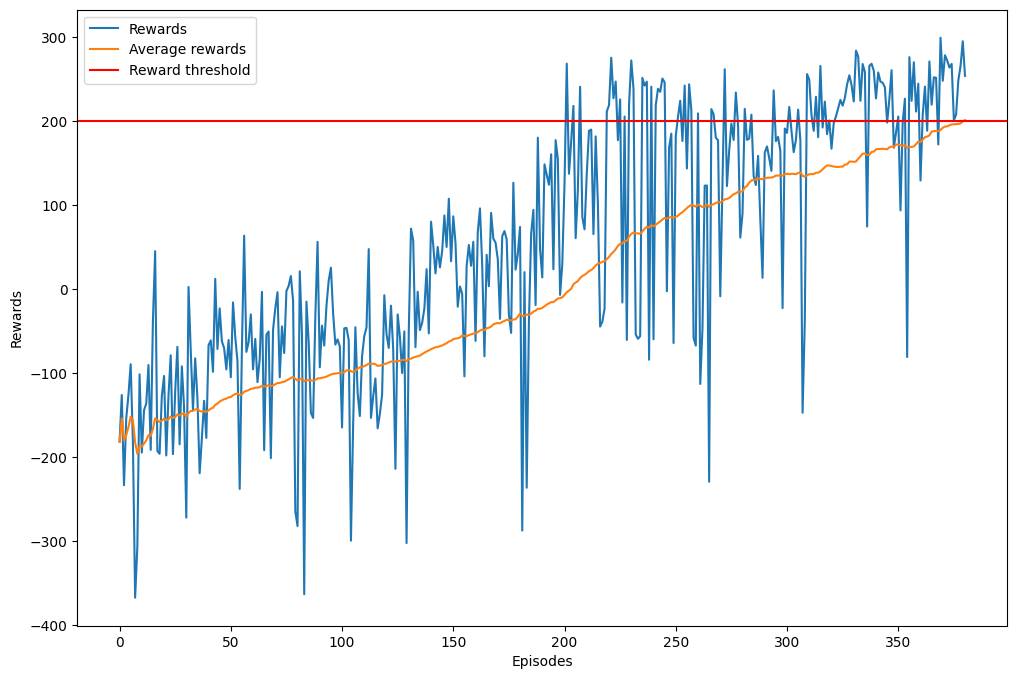

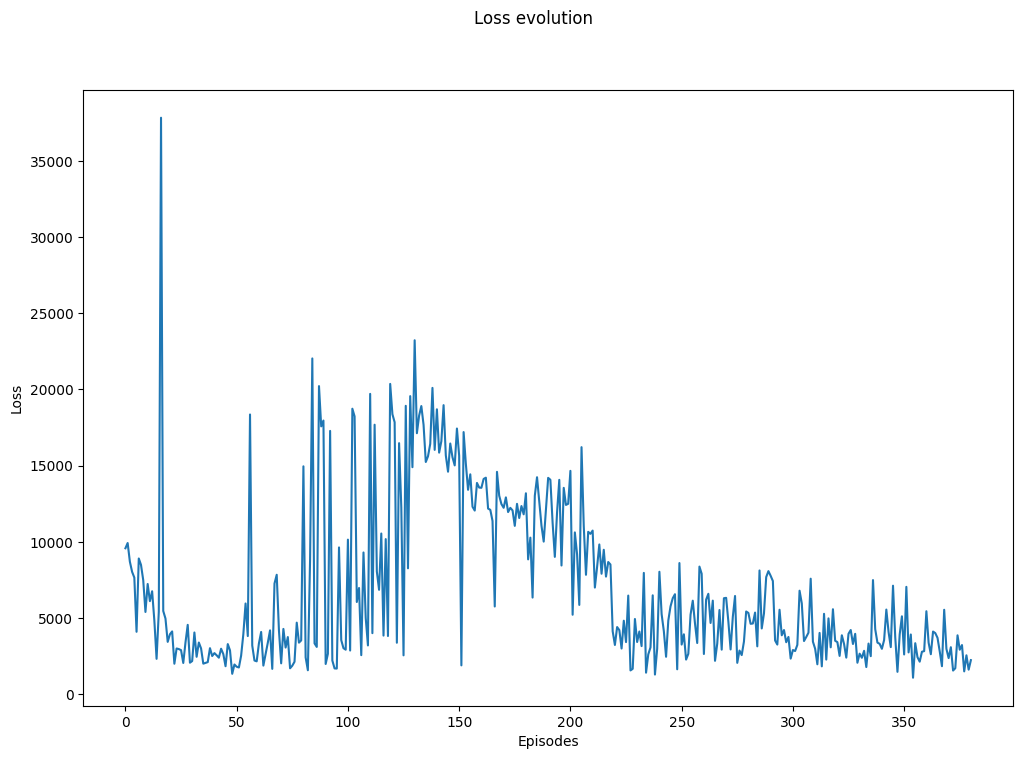

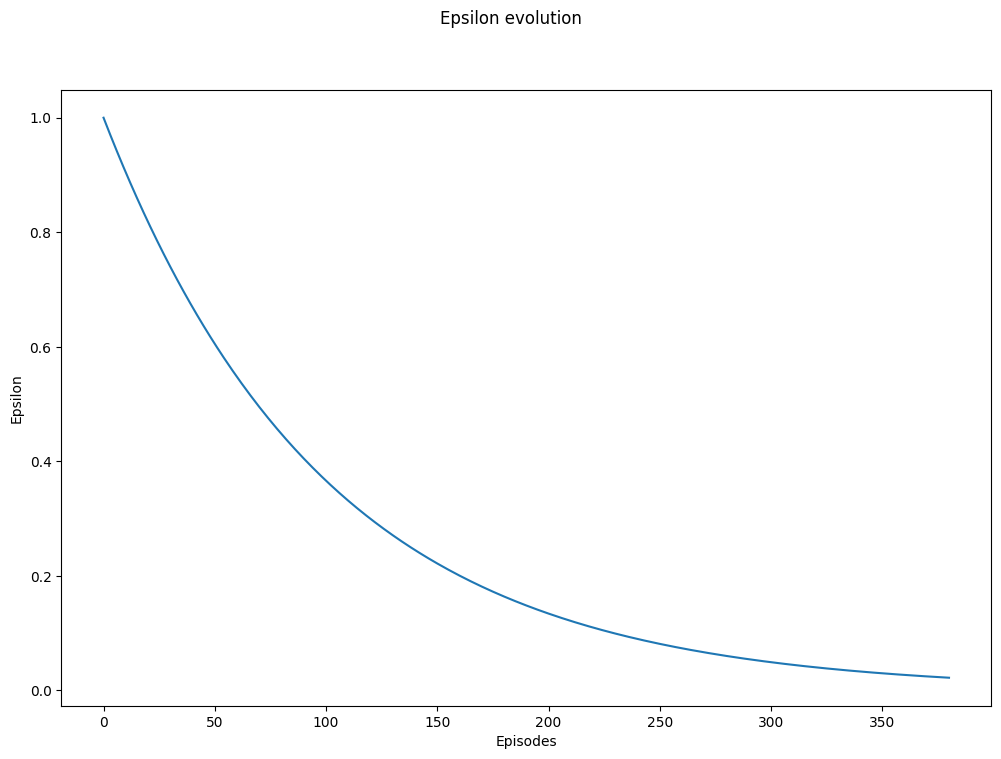

In [ ]:
agentDQN.plot_rewards()
agentDQN.plot_loss()
agentDQN.plot_epsilon()


### Save the trained model

In [11]:
torch.save(agentDQN.dnnetwork.state_dict(), "Classic_DQN_Model.pt")

### Load the trained model in case you want to run it from here

In [11]:
agentDQN.dnnetwork.load_state_dict(torch.load("Classic_DQN_Model.pt"))


<All keys matched successfully>

### Test the trained agent in a test environment

In [12]:
def play_game(env, ag):
    frames = []
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        observation, info = reset_result
    else:
        observation, info = reset_result, {}
    t=0
    total_reward=0

    done = False
    while not done:
        frame = env.render()
        if isinstance(frame, (list, tuple)):
            frame = frame[0]
        frames.append(frame)
        action = ag.dnnetwork.get_action(observation, epsilon=0.0)    # Use get_action to select the action; epsilon does not apply here   
        step_result = env.step(action)
        if isinstance(step_result, tuple) and len(step_result) == 5:
            observation, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            observation, reward, done, info = step_result

        total_reward += reward

        t+=1 # number of steps
    env.close()
    return t, total_reward, frames


In [19]:
results=[]
list_frames=[]
for i in range(20):
    _, r, frames = (play_game(env, agentDQN))
    results.append(r)
    list_frames.append(frames)

In [22]:
max_tuple = max(results)
max_tuple_index = results.index(max_tuple)
max_tuple_index

18

In [23]:
try:
    os.makedirs('videos')
except:
    pass

imageio.mimwrite(os.path.join('./', 'DQN_lunar_lander_neuronal.gif'), list_frames[max_tuple_index], fps=60)